In [24]:
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Preparing the Data

After loading we first prepare the data by factorizing the text fields

In [50]:
path = 'kddcup.data_10_percent_corrected'
kdd_data = pd.read_csv(path, header=None)

kdd_data[1], protocols = pd.factorize(kdd_data[1])
kdd_data[2], services = pd.factorize(kdd_data[2])
kdd_data[3], flags    = pd.factorize(kdd_data[3])
kdd_data[41], attacks = pd.factorize(kdd_data[41])
#kdd_data.head()

scaler = MinMaxScaler()
data_transformed= scaler.fit_transform(kdd_data)

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Calculate the Kmeans for different k

We decided to use the [Elbow Method][1] to determine which K is the best for representing the number of clusters therefore we are going through a range of clusters
You can see the full result in the picture below
![different_cluster_results.png](Different_Cluster_results.png) 
From this we can infer the optimal k is at 4.

[1]: https://en.wikipedia.org/wiki/Elbow_method_(clustering)

In [52]:
error = []
labels = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    error.append(km.inertia_)
    labels.append(km.labels_)

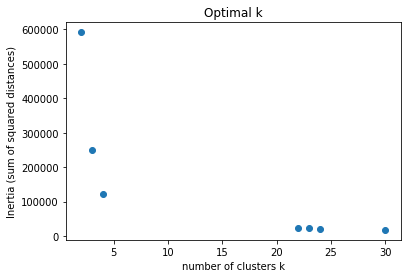

In [62]:
plt.plot(K, error, 'o')
plt.xlabel('number of clusters k')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Optimal k')
plt.show()

## Transforming via PCA

To visualize the clusters in a scatter plot we first transformed the data via PCA to be 3 Dimensional

In [67]:
pca = PCA(n_components=3).fit(data_transformed)
pca_3d = pca.transform(data_transformed)

You can see that the 4 clusters seem to seperate the data the best of all the results we have

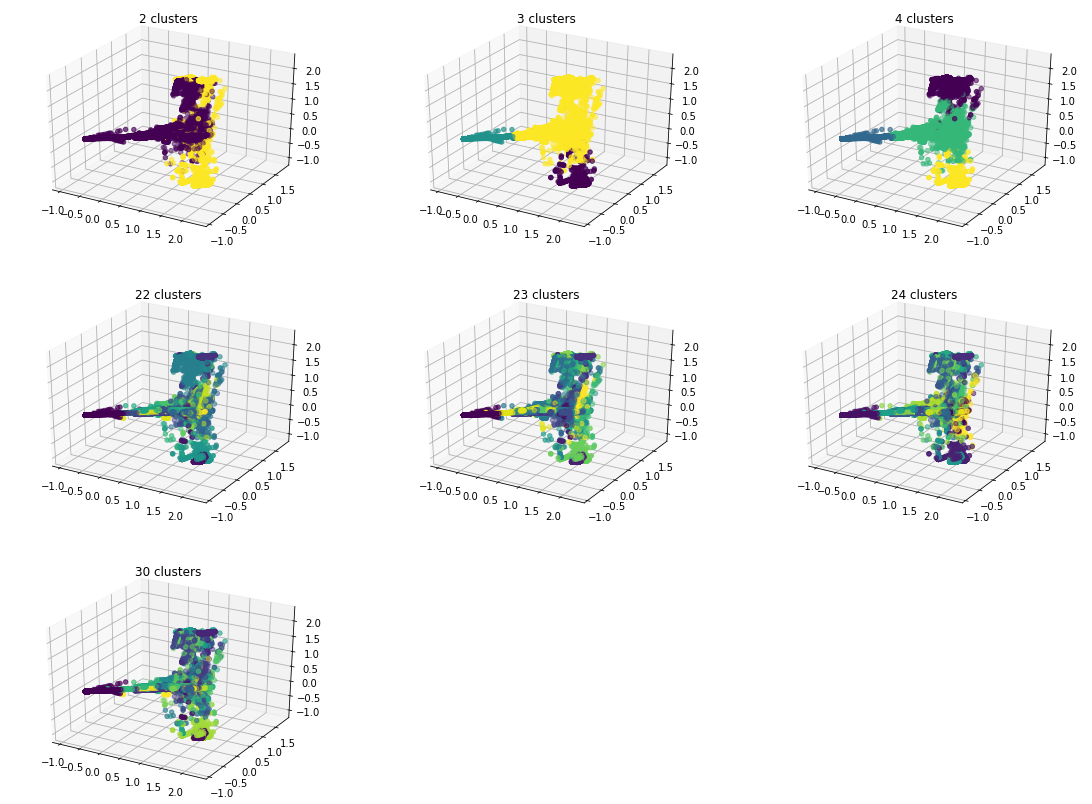

In [103]:
fig = plt.figure(figsize=(19.2, 14.4))
for index, label in enumerate(labels):
    ax = fig.add_subplot(3, 3, index+1, projection='3d')
    cluster_num = max(label)
    ax.set_title("{} clusters".format(cluster_num+1))
    ax.scatter(pca_3d[:,0],pca_3d[:,1], pca_3d[:,2], c=label)
plt.show()

# PCA before Kmeans

This time we attempt to reduce the dimensionality before clustering first to speed it up and second to see if there are any differences in the results

In [88]:
pca = PCA(n_components=3).fit(data_transformed)
pca_data_3d = pca.transform(data_transformed)

In [76]:
error_pca = []
labels_pca = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_data_3d)
    error_pca.append(km.inertia_)
    labels_pca.append(km.labels_)

As you can see below the the Elbow again is at point 4. So PCA didn't lose much information here.

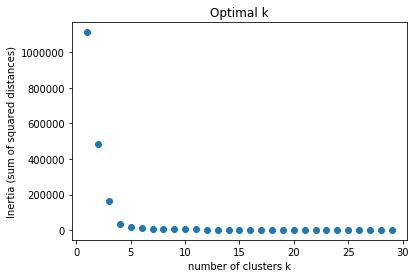

In [78]:
plt.plot(K, error_pca, 'o')
plt.xlabel('number of clusters k')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Optimal k')
plt.show()

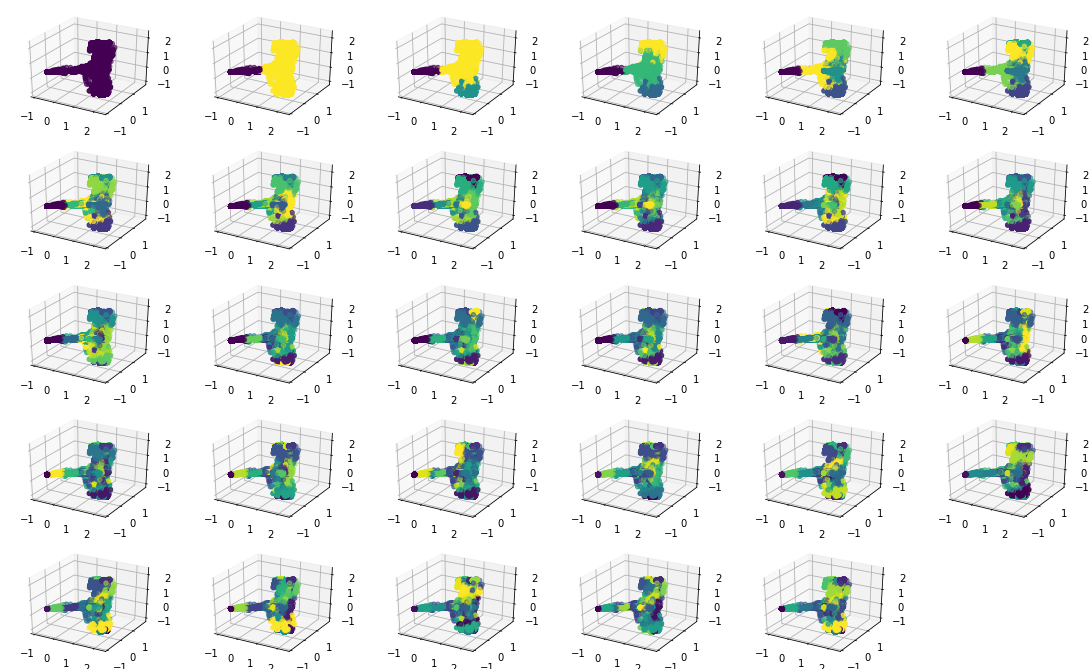

In [82]:
fig = plt.figure(figsize=(19.2, 14.4))
for index, label in enumerate(labels_pca):
    ax = fig.add_subplot(6,6, index+1, projection='3d')
    ax.scatter(pca_3d[:,0],pca_3d[:,1], pca_3d[:,2], c=label)
plt.show()

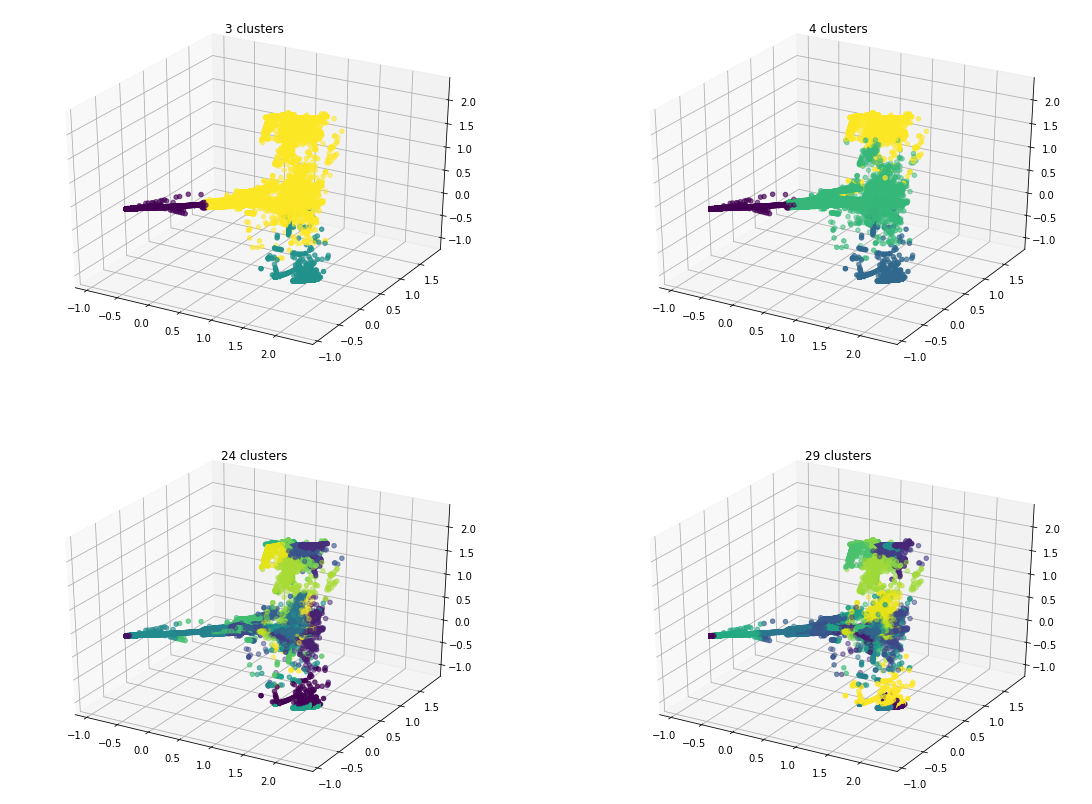

In [114]:
fig = plt.figure(figsize=(19.2, 14.4))
labels_selected = [labels_pca[2], labels_pca[3], labels_pca[23], labels_pca[28]]
for index, label in enumerate(labels_selected):
    ax = fig.add_subplot(2,2, index+1, projection='3d')
    cluster_number = max(label)+1
    ax.set_title("{} clusters".format(cluster_number))
    ax.scatter(pca_3d[:,0],pca_3d[:,1], pca_3d[:,2], c=label)
plt.show()